In [2]:
%load_ext autoreload
%autoreload 2

### Molecular Uncertainty
### t-SNE plot of epistemic uncertainty
MACCS keys http://www.mayachemtools.org/docs/modules/html/MACCSKeys.html

In [6]:
import os
import numpy as np
import pandas as pd
import proplot as pplt
import matplotlib.pyplot as plt
import pickle
import glob
import tensorflow as tf
import sklearn.metrics as skm
import uncertainty_toolbox as uct
import warnings
from timeit import default_timer as timer
from tqdm import tqdm
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import backend as K
from gnn_uq.load_data import load_data, split_data, get_data
from gnn_uq.gnn_model import gnn, nll, RegressionUQSpace
from gnn_uq.result import NLL, cNLL, miscal_area, sort_best_RE, calibrate, combine_result, conf_level
from gnn_uq.result import extract_functional_groups, calculate_silhouette_score
from rdkit import Chem
from rdkit.Chem import Descriptors, MACCSkeys
from rdkit.Chem.Draw import rdMolDraw2D, DrawingOptions
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

warnings.filterwarnings("ignore")

os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)

NAME = ['Lipo', 'ESOL', 'FreeSolv', 'QM7']
UNIT = [r'log D', r'log mol/L', r'kcal/mol', r'kcal/mol']

COLOR = []
cycle = pplt.Cycle('ggplot')
cycle2 = pplt.Cycle('Dark2')
for c in cycle:
    COLOR.append(c['color'])
for c in cycle2:
    COLOR.append(c['color'])

pplt.rc.cycle = 'ggplot'


In [9]:
with open("../result/val_test_result.pickle", "rb") as handle:
    result = pickle.load(handle)
    
with open("../result/val_test_result_random.pickle", "rb") as handle:
    result_random = pickle.load(handle)
    
def benchmark_result(dataset='Delaney', estimator='MPNN Ensemble'):
    benchmark = pd.read_csv('../data/benchmark_result.csv')
    benchmark = benchmark[
        (benchmark['Data Set'] == dataset) &
        (benchmark['Estimator'] == estimator) &
        (benchmark['Split'] == 'Random Split')
    ]

    return benchmark

### qm7

In [7]:
dataset = 'qm7'

tasks = ["qm7"]

seed = 0

data = get_data(f'../data/{dataset}.csv', tasks, max_data_size=None)

_, _, _, _, mol_test, y_test = split_data(data, split_type='random', sizes=(0.5, 0.2, 0.3), show_mol=True, seed=seed)

k_values = np.arange(3, 30)


mols = [Chem.MolFromSmiles(smi) for smi in mol_test]

fps = [MACCSkeys.GenMACCSKeys(mol) for mol in mols]

X = np.array(fps)

tsne = TSNE(n_components=2, random_state=0, n_jobs=-1)
X_tsne = tsne.fit_transform(X)

silhouette_scores = [calculate_silhouette_score(X_tsne, k) for k in k_values]

best_k = k_values[np.argmax(silhouette_scores)]

kmeans = KMeans(n_clusters=best_k, random_state=0)
clusters = kmeans.fit_predict(X_tsne)

print(f"# Best k = {best_k}")

Best k = 18


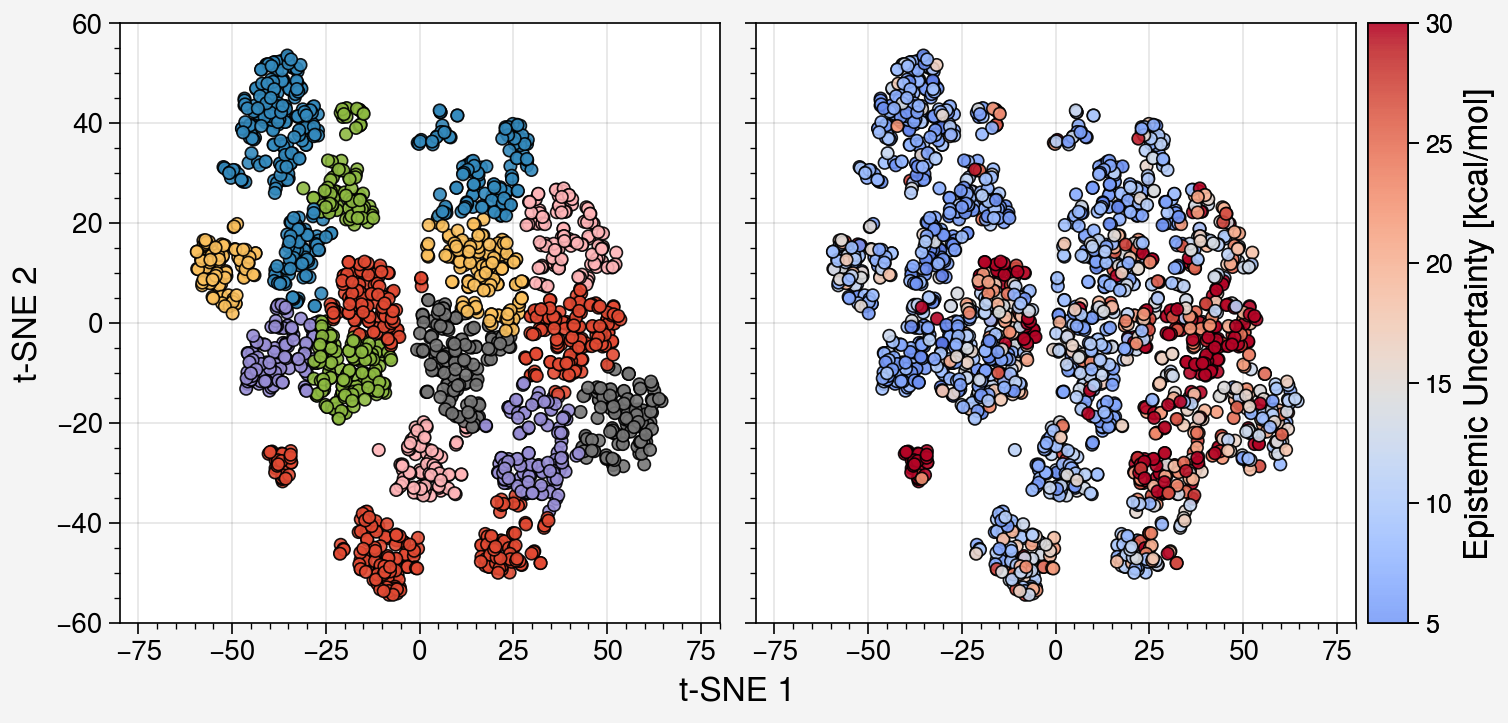

In [10]:
epis = []

for seed in range(1):

    y_true, y_pred, y_epis, y_alea, v_true, v_pred, v_epis, v_alea = result[(dataset.lower(), '523', seed)]

    epi = y_epis**0.5
    
    epis.append(epi)
    
epis = np.array(epis)
epi = np.mean(epis, axis=0)
epi.shape

vmin = epi.min()
vmax = epi.max()
mean_epi = epi.mean()
cmap = pplt.Colormap('coolwarm')

epi_sub_mean = epi-mean_epi

adjusted_vmin = np.percentile(epi_sub_mean, 10)
adjusted_vmax = np.percentile(epi_sub_mean, 90)

colors = (clusters - clusters.min()) / (clusters.max() - clusters.min())


fig, ax = pplt.subplots(ncols=2, refwidth=3, refheight=3)

im = ax[0].scatter(X_tsne[:, 0], X_tsne[:, 1], 
           alpha=0.9, edgecolor='k', s=20,
           c=clusters, cmap='ggplot')

im = ax[1].scatter(X_tsne[:, 0], X_tsne[:, 1], 
           alpha=0.9, edgecolor='k', s=20,
           c=epi_sub_mean, cmap='coolwarm', vmin=adjusted_vmin, vmax=adjusted_vmax)

cbar = fig.colorbar(im, ax=ax[1])
cbar.set_label(r'Epistemic Uncertainty [kcal/mol]', size=12)
cbar.set_ticks(np.linspace(adjusted_vmin, adjusted_vmax, num=6))
cbar.set_ticklabels([5, 10, 15, 20, 25, 30])

for i in range(2):
    ax[i].format(xlabel='t-SNE 1', ylabel='t-SNE 2', xlim=[-80, 80], ylim=[-60, 60],
                 xticklabelsize=10, yticklabelsize=10, xlabelsize=12, ylabelsize=12)
    
plt.savefig('../result/fig/tsne_qm7_epis.svg', bbox_inches='tight')

In [24]:
f1 = (X_tsne[:, 0] > -45)
f2 = (X_tsne[:, 0] < -30)
f3 = (X_tsne[:, 1] > -40)
f4 = (X_tsne[:, 1] < -20)

idx = np.where(f1 & f2 & f3 & f4)

mol_test[idx][:10]

array(['[H]C([H])([H])C#CS(=O)(=O)C([H])([H])[H]',
       '[H]OS([O])([O])C1([H])C([H])([H])C1([H])[H]',
       '[H]N([H])S(=O)(=O)C1([H])C([H])([H])C1([H])[H]',
       '[H]C([H])([H])C1([H])C([H])([H])S(=O)(=O)C1([H])[H]',
       '[H]C([H])([H])C1([H])OS([O])([O])C1([H])[H]',
       '[H]C1=C([H])S(=O)(=O)C([H])([H])C1([H])[H]',
       '[H]OC([H])([H])S(=O)(=O)C([H])=C([H])[H]',
       '[H]C#CS([O])([O])OC([H])([H])[H]', '[H]C#CS(=O)(=O)C#N',
       '[H]C([H])=C(C([H])([H])[H])S(=O)(=O)N([H])[H]'], dtype='<U78')

In [23]:
f1 = (X_tsne[:, 0] > -50)
f2 = (X_tsne[:, 0] < -25)
f3 = (X_tsne[:, 1] > 10)
f4 = (X_tsne[:, 1] < 50)

idx = np.where(f1 & f2 & f3 & f4)

mol_test[idx][:10]

array(['[H]C([H])=C([H])OC([H])([H])C([H])([H])OC([H])([H])[H]',
       '[H]C([H])([H])C1([H])C([H])([H])C([H])([H])C2([H])OC21[H]',
       '[H]C1=C(OC([H])(C([H])([H])[H])C1([H])[H])C([H])([H])[H]',
       '[H]OC1([H])C([H])([H])C([H])([H])OC([H])([H])C1([H])[H]',
       '[H]C(=O)C1=C([H])C([H])([H])OC1([H])[H]',
       '[H]C(=O)C([H])(C([H])([H])[H])C1([H])OC1([H])[H]',
       '[H]C([H])([H])C([H])([H])OC([H])([H])C1([H])OC1([H])[H]',
       '[H]C(=O)C([H])([H])OC([H])([H])C([H])=C([H])[H]',
       '[H]C([H])=C([H])C1([H])OC([H])([H])C1([H])C([H])([H])[H]',
       '[H]C([H])([H])C([H])([H])C1([H])OC([H])([H])C([H])([H])C1([H])[H]'],
      dtype='<U78')

In [25]:
f1 = (X_tsne[:, 0] > -50)
f2 = (X_tsne[:, 0] < -25)
f3 = (X_tsne[:, 1] > -20)
f4 = (X_tsne[:, 1] < 0)

idx = np.where(f1 & f2 & f3 & f4)

mol_test[idx][:10]

array(['[H]C([H])=C([H])OC(C([H])([H])[H])(C([H])([H])[H])C([H])([H])[H]',
       '[H]C(C(=O)C([H])([H])[H])=C(C([H])([H])[H])C([H])([H])[H]',
       '[H]C#CC([H])=C([H])OC([H])=O',
       '[H]C(=O)C([H])([H])C(OC([H])([H])[H])=C([H])[H]',
       '[H]C(=O)C([H])=C([H])C([H])=O',
       '[H]C([H])=C([H])C(=O)OC([H])([H])[H]',
       '[H]OC([H])(C([H])=C([H])C([H])([H])[H])C([H])([H])[H]',
       '[H]C#CC([H])(O[H])C([H])=C([H])C([H])([H])[H]',
       '[H]C#CC(=O)C([H])(C([H])([H])[H])C([H])([H])[H]',
       '[H]C(OC([H])([H])[H])=C(OC([H])([H])[H])C([H])([H])[H]'],
      dtype='<U78')

In [27]:
f1 = (X_tsne[:, 0] > 25)
f2 = (X_tsne[:, 0] < 60)
f3 = (X_tsne[:, 1] > -15)
f4 = (X_tsne[:, 1] < 10)

idx = np.where(f1 & f2 & f3 & f4)

mol_test[idx][:10]

array(['[H]N(C([H])([H])[H])C1([H])C([H])([H])C1([H])C([H])([H])C([H])([H])[H]',
       '[H]C([H])=C([H])C([H])(N([H])[H])C1([H])N([H])C1([H])[H]',
       '[H]N(C([H])([H])[H])C([H])([H])C1(N([H])[H])C([H])([H])C1([H])[H]',
       '[H]C#CC1([H])N([H])C1([H])C([H])=O',
       '[H]N1C2([H])C([H])([H])C([H])([H])C([H])([H])C1([H])C2([H])[H]',
       '[H]C([H])=C1N([H])C(=O)C([H])([H])C1([H])[H]',
       '[H]C(=O)C1([H])N([H])C1([H])C([H])([H])C([H])([H])[H]',
       '[H]C([H])=C1C([H])=C([H])C(=O)N1[H]',
       '[H]C1=C([H])C([H])(C#N)N([H])C1([H])[H]',
       '[H]C([H])=C([H])C(=C([H])[H])C1([H])N([H])C1([H])[H]'],
      dtype='<U78')

In [29]:
f1 = (X_tsne[:, 0] > 15)
f2 = (X_tsne[:, 0] < 45)
f3 = (X_tsne[:, 1] > -30)
f4 = (X_tsne[:, 1] < -10)

idx = np.where(f1 & f2 & f3 & f4)

mol_test[idx][:10]

array(['[H]C1=NC([H])([H])C2(N1[H])C([H])([H])C2([H])[H]',
       '[H]C1C([H])=C(N([H])C=1C([H])([H])[H])C([H])([H])[H]',
       '[H]C1([H])C2=NSN=C2C1([H])[H]',
       '[H][N][C]1N([H])C([H])=C([H])C1([H])[H]',
       '[H]C([H])=C1N([H])C(=O)C([H])([H])C1([H])[H]',
       '[H]C([H])=C1C([H])=C([H])C(=O)N1[H]',
       '[H]C1C(=NN([H])C=1[H])C([H])([H])[H]',
       '[H]C1=NC([H])([H])C2([H])C([H])([H])C2([H])N1[H]',
       '[H]C1=NN=C(C([H])([H])[H])C([H])([H])C1([H])[H]',
       '[H]C1SN=C(C=1[H])C([H])([H])N([H])[H]'], dtype='<U78')

### ESOL

In [31]:
dataset = 'delaney'

tasks = ["logSolubility"]


seed = 0

data = get_data(f'../data/{dataset}.csv', tasks, max_data_size=None)

_, _, _, _, mol_test, y_test = split_data(data, split_type='random', sizes=(0.5, 0.2, 0.3), show_mol=True, seed=seed)

k_values = np.arange(3, 30)



mols = [Chem.MolFromSmiles(smi) for smi in mol_test]

fps = [MACCSkeys.GenMACCSKeys(mol) for mol in mols]

X = np.array(fps)

tsne = TSNE(n_components=2, random_state=0, n_jobs=-1)
X_tsne = tsne.fit_transform(X)

silhouette_scores = [calculate_silhouette_score(X_tsne, k) for k in k_values]

best_k = k_values[np.argmax(silhouette_scores)]

kmeans = KMeans(n_clusters=best_k, random_state=0)
clusters = kmeans.fit_predict(X_tsne)

print(f"# Best k = {best_k}")

# Best k = 29


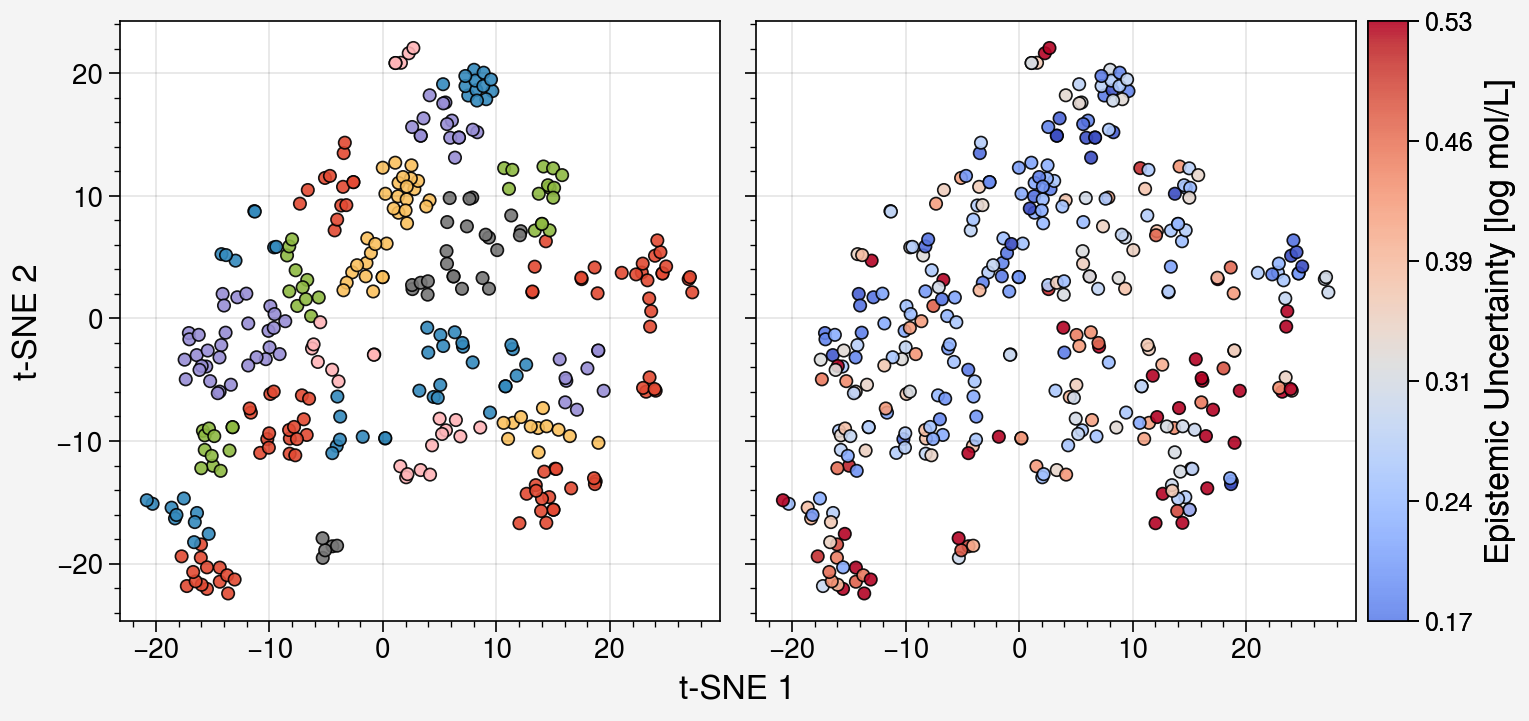

In [32]:
epis = []

for seed in range(1):

    y_true, y_pred, y_epis, y_alea, v_true, v_pred, v_epis, v_alea = result[(dataset.lower(), '523', seed)]

    epi = y_epis**0.5
    
    epis.append(epi)
    
epis = np.array(epis)
epi = np.mean(epis, axis=0)

vmin = epi.min()
vmax = epi.max()
mean_epi = epi.mean()
cmap = pplt.Colormap('coolwarm')

epi_sub_mean = epi-mean_epi

adjusted_vmin = np.percentile(epi_sub_mean, 10)
adjusted_vmax = np.percentile(epi_sub_mean, 90)

colors = (clusters - clusters.min()) / (clusters.max() - clusters.min())


fig, ax = pplt.subplots(ncols=2, refwidth=3, refheight=3)

im = ax[0].scatter(X_tsne[:, 0], X_tsne[:, 1], 
           alpha=0.9, edgecolor='k', s=20,
           c=clusters, cmap='ggplot')

im = ax[1].scatter(X_tsne[:, 0], X_tsne[:, 1], 
           alpha=0.9, edgecolor='k', s=20,
           c=epi_sub_mean, cmap='coolwarm', vmin=adjusted_vmin, vmax=adjusted_vmax)

cbar = fig.colorbar(im, ax=ax[1])
cbar.set_label(r'Epistemic Uncertainty [log mol/L]', size=12)
cbar.set_ticks(np.linspace(adjusted_vmin, adjusted_vmax, num=6))
cbar.set_ticklabels(np.round(np.linspace(adjusted_vmin, adjusted_vmax, num=6)+mean_epi, 2))

for i in range(2):
    ax[i].format(xlabel='t-SNE 1', ylabel='t-SNE 2',
                 xticklabelsize=10, yticklabelsize=10, xlabelsize=12, ylabelsize=12)
    

plt.savefig('../result/fig/tsne_esol.svg')


### Lipo

In [33]:
dataset = 'lipo'

tasks = ["lipo"]

seed = 0

data = get_data(f'../data/{dataset}.csv', tasks, max_data_size=None)

_, _, _, _, mol_test, y_test = split_data(data, split_type='random', sizes=(0.5, 0.2, 0.3), show_mol=True, seed=seed)

k_values = np.arange(3, 30)



mols = [Chem.MolFromSmiles(smi) for smi in mol_test]

fps = [MACCSkeys.GenMACCSKeys(mol) for mol in mols]

X = np.array(fps)

tsne = TSNE(n_components=2, random_state=0, n_jobs=-1)
X_tsne = tsne.fit_transform(X)

silhouette_scores = [calculate_silhouette_score(X_tsne, k) for k in k_values]

best_k = k_values[np.argmax(silhouette_scores)]

kmeans = KMeans(n_clusters=best_k, random_state=0)
clusters = kmeans.fit_predict(X_tsne)

print(f"# Best k = {best_k}")

# Best k = 3


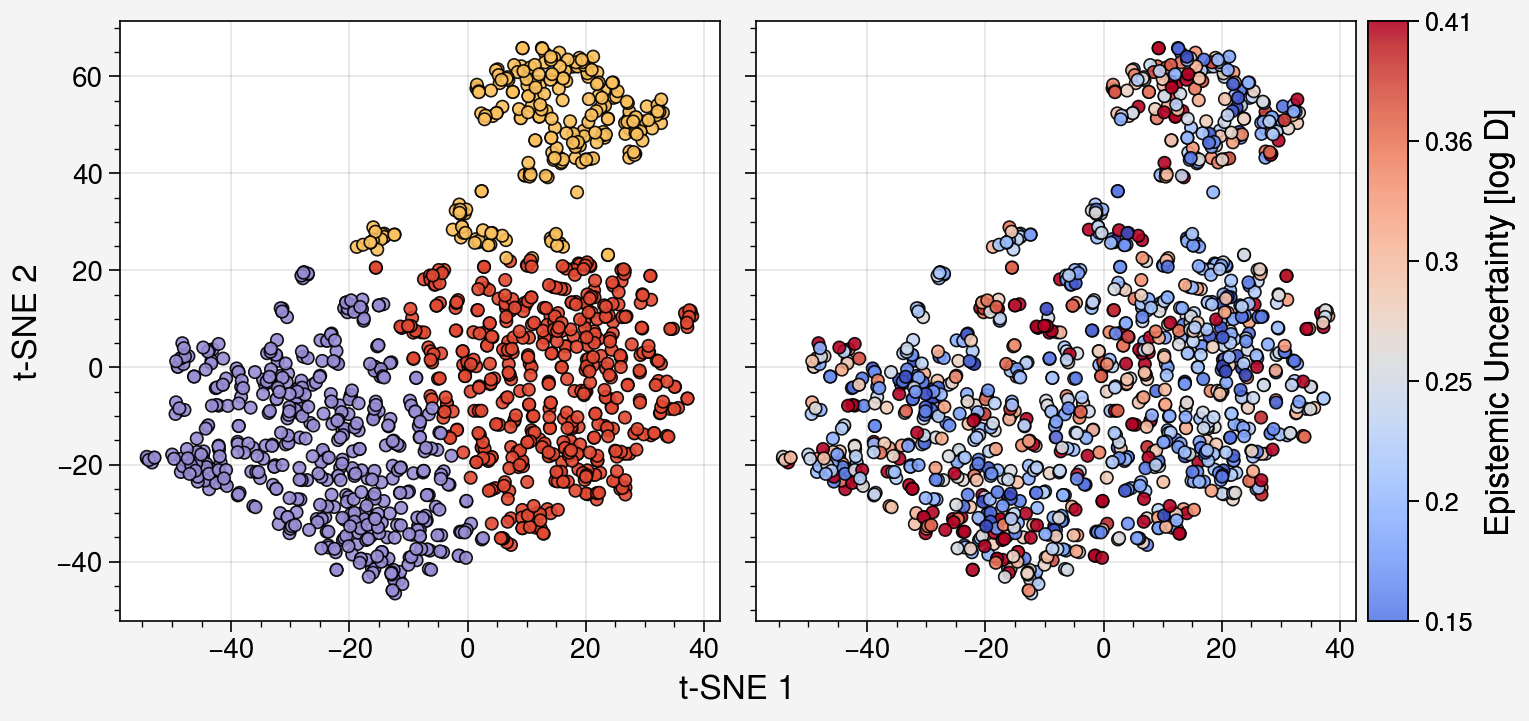

In [34]:
epis = []

for seed in range(1):

    y_true, y_pred, y_epis, y_alea, v_true, v_pred, v_epis, v_alea = result[(dataset.lower(), '523', seed)]

    epi = y_epis**0.5
    
    epis.append(epi)
    
epis = np.array(epis)
epi = np.mean(epis, axis=0)
vmin = epi.min()
vmax = epi.max()
mean_epi = epi.mean()
cmap = pplt.Colormap('coolwarm')

epi_sub_mean = epi-mean_epi

adjusted_vmin = np.percentile(epi_sub_mean, 10)
adjusted_vmax = np.percentile(epi_sub_mean, 90)

colors = (clusters - clusters.min()) / (clusters.max() - clusters.min())


fig, ax = pplt.subplots(ncols=2, refwidth=3, refheight=3)

im = ax[0].scatter(X_tsne[:, 0], X_tsne[:, 1], 
           alpha=0.9, edgecolor='k', s=20,
           c=clusters, cmap='ggplot')

im = ax[1].scatter(X_tsne[:, 0], X_tsne[:, 1], 
           alpha=0.9, edgecolor='k', s=20,
           c=epi_sub_mean, cmap='coolwarm', vmin=adjusted_vmin, vmax=adjusted_vmax)

cbar = fig.colorbar(im, ax=ax[1])
cbar.set_label(r'Epistemic Uncertainty [log D]', size=12)
cbar.set_ticks(np.linspace(adjusted_vmin, adjusted_vmax, num=6))
cbar.set_ticklabels(np.round(np.linspace(adjusted_vmin, adjusted_vmax, num=6)+mean_epi, 2))

for i in range(2):
    ax[i].format(xlabel='t-SNE 1', ylabel='t-SNE 2',
                 xticklabelsize=10, yticklabelsize=10, xlabelsize=12, ylabelsize=12)
    

plt.savefig('../result/fig/tsne_lipo.svg')


In [35]:
dataset = 'freesolv'

tasks = ["freesolv"]


seed = 0

data = get_data(f'../data/{dataset}.csv', tasks, max_data_size=None)

_, _, _, _, mol_test, y_test = split_data(data, split_type='random', sizes=(0.5, 0.2, 0.3), show_mol=True, seed=seed)

k_values = np.arange(3, 30)



mols = [Chem.MolFromSmiles(smi) for smi in mol_test]

fps = [MACCSkeys.GenMACCSKeys(mol) for mol in mols]

X = np.array(fps)

tsne = TSNE(n_components=2, random_state=0, n_jobs=-1)
X_tsne = tsne.fit_transform(X)

silhouette_scores = [calculate_silhouette_score(X_tsne, k) for k in k_values]

best_k = k_values[np.argmax(silhouette_scores)]

kmeans = KMeans(n_clusters=best_k, random_state=0)
clusters = kmeans.fit_predict(X_tsne)

print(f"# Best k = {best_k}")

# Best k = 29


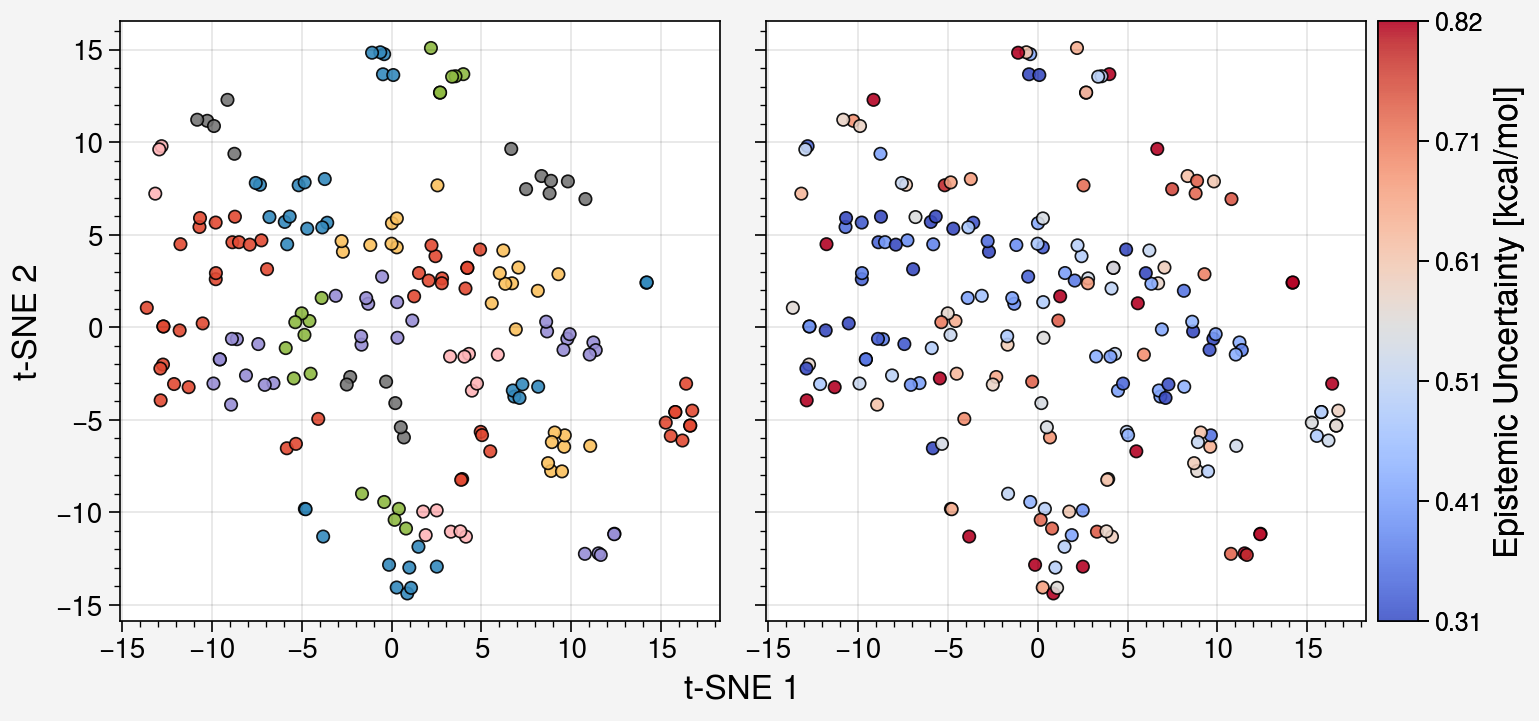

In [36]:
epis = []

for seed in range(1):

    y_true, y_pred, y_epis, y_alea, v_true, v_pred, v_epis, v_alea = result[(dataset.lower(), '523', seed)]

    epi = y_epis**0.5
    
    epis.append(epi)
    
epis = np.array(epis)
epi = np.mean(epis, axis=0)

vmin = epi.min()
vmax = epi.max()
mean_epi = epi.mean()
cmap = pplt.Colormap('coolwarm')

epi_sub_mean = epi-mean_epi

adjusted_vmin = np.percentile(epi_sub_mean, 10)
adjusted_vmax = np.percentile(epi_sub_mean, 90)

colors = (clusters - clusters.min()) / (clusters.max() - clusters.min())


fig, ax = pplt.subplots(ncols=2, refwidth=3, refheight=3)

im = ax[0].scatter(X_tsne[:, 0], X_tsne[:, 1], 
           alpha=0.9, edgecolor='k', s=20,
           c=clusters, cmap='ggplot')

im = ax[1].scatter(X_tsne[:, 0], X_tsne[:, 1], 
           alpha=0.9, edgecolor='k', s=20,
           c=epi_sub_mean, cmap='coolwarm', vmin=adjusted_vmin, vmax=adjusted_vmax)

cbar = fig.colorbar(im, ax=ax[1])
cbar.set_label(r'Epistemic Uncertainty [kcal/mol]', size=12)
cbar.set_ticks(np.linspace(adjusted_vmin, adjusted_vmax, num=6))
cbar.set_ticklabels(np.round(np.linspace(adjusted_vmin, adjusted_vmax, num=6)+mean_epi, 2))

for i in range(2):
    ax[i].format(xlabel='t-SNE 1', ylabel='t-SNE 2',
                 xticklabelsize=10, yticklabelsize=10, xlabelsize=12, ylabelsize=12)
    
plt.savefig('../result/fig/tsne_freesolv.svg')